In [31]:
"""
Magic commands
"""
%matplotlib inline
%load_ext autoreload
%autoreload 2

"""
Python standard packages
"""
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math
"""
Own packages
"""
sys.path.insert(0, "C:\\code\\speciale\\") # vesl path
sys.path.insert(0, "C:\\Users\\lucas\\OneDrive\\Skrivebord\\repo\\speciale\\") # ljb path

from market_simulation_study.agent import RandomAgent, InvestorAgent, TrendAgent, RLAgent, MarketMakerAgent
from market_simulation_study.environment import MarketEnvironment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
def generate_xy(data, time_steps):
    # Indices of target array
    #data_y = data["reward"]
    data_y = data[:, -1]
    y_ind = np.arange(time_steps, len(data_y), time_steps)
    y = data_y[y_ind]
    # Prepare X
    rows_x = len(y)
    data_x = data[:,:-1]
    #scaler = MinMaxScaler(feature_range=(0, 1)) 
    #data_x = scaler.fit_transform(data_x)
    x = data_x[range(time_steps*rows_x), :]
    n_features = data_x.shape[1]
    x = np.reshape(x, (rows_x, time_steps, n_features))
    return x, y


In [71]:
df_rl = pd.read_feather('data/data_test.feather').dropna()
#n_time_points = 2000
# df_rl = pd.DataFrame({'p': [100 + 20 * np.sin(zz) for zz in np.linspace(0,20,n_time_points)], 
#                       'rnoise': [random.random() for zz in np.linspace(0,20,n_time_points)],
#                       'reward': [100 + 20 * np.sin(zz) for zz in np.linspace(0,20,n_time_points)]})
cols = df_rl.columns
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_reward = MinMaxScaler(feature_range=(0, 1))
scaler_fitted = scaler_reward.fit(df_rl["reward"].to_numpy().reshape(-1, 1))
df_rl = pd.DataFrame(scaler.fit_transform(df_rl), columns = cols)
#df_rl["reward"] = np.abs(df_rl["reward"])
data_x = df_rl.iloc[:, :-1]
data_y = df_rl['reward']
data_len = data_x.shape[0]
test_ratio = 0.3
time_steps = 1 # Number of previous timesteps to use for prediction 
row_split = int((data_len * (1-test_ratio)))

data_train, data_test = df_rl.iloc[:row_split,:], df_rl.iloc[row_split:, :]
data_train, data_test = data_train.to_numpy(), data_test.to_numpy()
x_train, y_train = generate_xy(data_train, time_steps)
x_test, y_test = generate_xy(data_test, time_steps)
#x_train, x_test = data_x.iloc[:row_split,:], data_x.iloc[row_split:,:]
#y_train, y_test = data_y.iloc[:row_split], data_y.iloc[row_split:]
#x_train = np.reshape(x_train, (row_split, time_steps, 1))
#x_test = np.reshape(x_test, (data_len - row_split, time_steps, 1))

In [76]:
batch_size = 1
def nn(hidden_units, dense_units, input_shape, activation):    
    model = Sequential()
#     model.add(SimpleRNN(hidden_units, input_shape=input_shape, 
#                         activation=activation[0]))
#     model.add(LSTM(hidden_units, batch_input_shape=(batch_size, time_steps, 5), stateful=True, return_sequences=True))
#     model.add(LSTM(hidden_units, batch_input_shape=(batch_size, time_steps, 5), stateful=True))
    model.add(LSTM(hidden_units, input_shape=(time_steps, 5), return_sequences=True))
    model.add(LSTM(hidden_units, input_shape=(time_steps, 5)))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [77]:
model = nn(hidden_units=16, dense_units=1, input_shape=(time_steps, 5), 
                   activation=['relu', 'linear'])
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)
#model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
12599/12599 - 11s - loss: 0.0046
Epoch 2/10
12599/12599 - 10s - loss: 2.5476e-04
Epoch 3/10
12599/12599 - 9s - loss: 2.4819e-04
Epoch 4/10
12599/12599 - 10s - loss: 2.3638e-04
Epoch 5/10
12599/12599 - 9s - loss: 2.3441e-04
Epoch 6/10
12599/12599 - 9s - loss: 2.2264e-04
Epoch 7/10
12599/12599 - 10s - loss: 2.2781e-04
Epoch 8/10
12599/12599 - 9s - loss: 2.1662e-04
Epoch 9/10
12599/12599 - 9s - loss: 2.1234e-04
Epoch 10/10
12599/12599 - 10s - loss: 2.1034e-04


In [69]:
def print_error(trainY, testY, train_predict, test_predict):
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))
    return 
 

# predictions
train_predict = model.predict(x_train, batch_size = 1)
test_predict = model.predict(x_test, batch_size = 1)
train_predict = scaler_fitted.inverse_transform(train_predict)
y_train = scaler_fitted.inverse_transform([y_train])
test_predict = scaler_fitted.inverse_transform(test_predict)
y_test = scaler_fitted.inverse_transform([y_test])
# Mean square error
print_error(y_train.reshape(451, 1), y_test.reshape(193, 1), train_predict, test_predict)

ValueError: cannot reshape array of size 12599 into shape (451,1)

In [78]:
[[ 1.9890099 -0.0019967]]
[[ 1.98681429 -0.0021956 ]]
[[ 1.98442001 -0.00239428]]
[[ 1.98182728 -0.00259273]]
[[ 1.97903638 -0.00279091]]
[[ 1.97604756 -0.00298881]]
[[ 1.97286115 -0.00318642]]

-0.000599919999999976

In [95]:
#states = []
states.append([ 3 - 1])
states

[[2], [2], [2], [2], [2]]

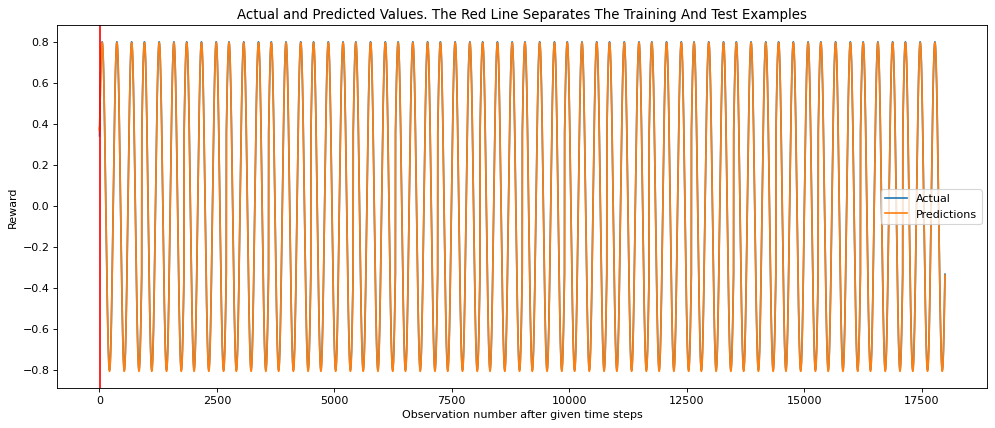

In [70]:
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Reward')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
plot_result(y_train, y_test, train_predict, test_predict)

In [15]:
df_rl = pd.read_feather('data/rl_state_space.feather').dropna()
instantaneous_rewards = df_rl["reward"].values

disc_reward = np.zeros_like(y_data)
gamma = 0.99
cum_reward = 0
for i in reversed(range(len(y_data))):
    cum_reward = cum_reward * gamma + instantaneous_rewards[i]
    disc_reward[i] = cum_reward

# disc_reward[2] = y_data[2]
# disc_reward[1] = gamma * y_data[2] + y_data[1]
# disc_reward[0] = (gamma * y_data[2] + y_data[1]) * gamma + y_data[0]

In [197]:
# Declare parameters
n_random_agents= 2
n_investor_agents = 0
n_trend_agents = 2
n_rl_agents = 0

n_agents = n_random_agents + n_investor_agents + n_trend_agents + n_rl_agents


time_periods = 50

price_list = [100 + np.random.normal() for j in range(100)]
ex_list = np.array([[0]*n_agents, [0]*n_agents])
fee = 0
slippage = 0
mean_buy_price = 99
mean_sell_price = 101

state0 = {"market_prices": price_list, "execution_status": ex_list, 'fee':fee, "mean_buy_price":mean_buy_price,
          "mean_sell_price":mean_sell_price, 'slippage':slippage}

env = MarketEnvironment(state0)
agents = []

random_agents = [RandomAgent(agent_id = j,
                             delta = np.random.normal()) for j in range(n_random_agents)]

investor_agents = [InvestorAgent(agent_id = j + n_random_agents,
                                 delta = np.random.normal(),
                                 intensity = 0.1) for j in range(n_investor_agents)]

trend_agents = [TrendAgent(agent_id = j + n_random_agents + n_investor_agents,
                                 delta = np.random.normal()) for j in range(n_trend_agents)]

rl_agents = [RLAgent(agent_id = j + n_random_agents + n_investor_agents + n_trend_agents,
                                 delta = np.random.normal()) for j in range(n_rl_agents)]

agents.append(random_agents)
agents.append(investor_agents)
agents.append(trend_agents)
agents.append(rl_agents)

agents = [item for sublist in agents for item in sublist]

# Initialize agents
for j in range(n_agents):
        agents[j].update(state0)

In [208]:
# INITIALIZE ORDER BOOKS
sell_order_book = agents[0].sell_order
buy_order_book = agents[0].buy_order
sell_order_book = pd.DataFrame(sell_order_book, index = sell_order_book.iloc[:, -1])
buy_order_book = pd.DataFrame(buy_order_book, index = buy_order_book.iloc[:, -1])

for i in range(len(agents)-1):
    #========================================#
    # CHECK IF AGENT i CAN MAKE A BUY TRADE #
    #========================================#
    if any(agents[i+1].buy_order["buy_price"].values >= sell_order_book.iloc[:, 0].values):
        print("price_match: ", agents[i+1].buy_order["buy_price"].values, sell_order_book.iloc[:, 0].values)
        
        matched_order_book = sell_order_book[sell_order_book["sell_price"].values <= agents[i+1].buy_order["buy_price"].values]
        matched_order_book = matched_order_book.sort_values(["sell_price", "latency"], ascending = [True, True])
        display(sell_order_book)
        display(agents[i+1].buy_order)
        for index, order in matched_order_book.iterrows():
            if agents[i+1].buy_order["buy_volume"].values > order["sell_volume"]:
                trade_volume = order["sell_volume"].copy()
            else:
                trade_volume = agents[i+1].buy_order["buy_volume"].values.copy()
            
            agents[i+1].buy_order["buy_volume"] -= trade_volume
            agents[int(order["agent_id"])].sell_order["sell_volume"] -= trade_volume
            sell_order_book.at[index, 'sell_volume'] -= trade_volume
            
            agents[i+1].position += trade_volume
            agents[int(order["agent_id"])].position -= trade_volume
            
    # SELL ORDER INTO SELL ORDER
    sell_order_book = sell_order_book[sell_order_book["sell_volume"] > 0]
    if agents[i+1].buy_order["buy_volume"].values > 0:
        buy_order_book = buy_order_book.append(agents[i+1].buy_order)
    
    sell_order_book = pd.DataFrame(sell_order_book, index = sell_order_book.iloc[:, -1])
    buy_order_book = pd.DataFrame(buy_order_book, index = buy_order_book.iloc[:, -1])
    
    #========================================#
    # CHECK IF AGENT i CAN MAKE A SELL TRADE #
    #========================================#
    if any(agents[i+1].sell_order["sell_price"].values <= buy_order_book.iloc[:, 0].values):
        print("price_match: ", agents[i+1].sell_order["sell_price"].values, buy_order_book.iloc[:, 0].values)
        
        matched_order_book = buy_order_book[buy_order_book["buy_price"].values >= agents[i+1].sell_order["sell_price"].values]
        matched_order_book = matched_order_book.sort_values(["buy_price", "latency"], ascending = [True, True])
        display(matched_order_book)
        for index, order in matched_order_book.iterrows():
            if agents[i+1].sell_order["sell_volume"].values > order["buy_volume"]:
                trade_volume = order["buy_volume"].copy()
            else:
                trade_volume = agents[i+1].sell_order["sell_volume"].values.copy()
            print(sell_order_book, " INDEX: ", index, " AGENT ID: ", order["agent_id"])
            
            agents[i+1].sell_order["sell_volume"] -= trade_volume
            agents[int(order["agent_id"])].buy_order["buy_volume"] -= trade_volume
            buy_order_book.at[index, 'buy_volume'] -= trade_volume
            
            agents[i+1].position -= trade_volume
            agents[int(order["agent_id"])].position = trade_volume
            # agents[sob["ID"]].all_trades.append([order["BP"], - trade_volume])

    # buy ORDER INTO buy ORDER
    buy_order_book = buy_order_book[buy_order_book["buy_volume"] > 0]
    if agents[i+1].sell_order["sell_volume"].values > 0:
        sell_order_book = sell_order_book.append(agents[i+1].sell_order)    
    
    sell_order_book = pd.DataFrame(sell_order_book, index = sell_order_book.iloc[:, -1])
    buy_order_book = pd.DataFrame(buy_order_book, index = buy_order_book.iloc[:, -1])


In [204]:
agents[1].position

-1.0

In [209]:
display(buy_order_book)
display(sell_order_book)

,buy_price,buy_volume,latency,agent_id
agent_id,,,,
0.0,98.466502,1.0,0.984619,0.0
1.0,96.864411,1.0,0.580663,1.0
2.0,105.220009,5.0,2.441061,2.0
3.0,107.921702,3.0,-0.965091,3.0


,sell_price,sell_volume,latency,agent_id
agent_id,,,,


In [210]:
display(agents[0].sell_order)
display(agents[1].sell_order)
display(agents[2].sell_order)
display(agents[3].sell_order)
display(agents[0].buy_order)
display(agents[1].buy_order)
display(agents[2].buy_order)
display(agents[3].buy_order)

,sell_price,sell_volume,latency,agent_id
0,110.508789,0.0,0.984619,0.0


,sell_price,sell_volume,latency,agent_id
1,107.524955,0.0,0.580663,1.0


,sell_price,sell_volume,latency,agent_id
2,NaN,0.0,2.441061,2.0


,sell_price,sell_volume,latency,agent_id
3,NaN,0.0,-0.965091,3.0


,buy_price,buy_volume,latency,agent_id
0,98.466502,1.0,0.984619,0.0


,buy_price,buy_volume,latency,agent_id
1,96.864411,1.0,0.580663,1.0


,buy_price,buy_volume,latency,agent_id
2,105.220009,5.0,2.441061,2.0


,buy_price,buy_volume,latency,agent_id
3,107.921702,3.0,-0.965091,3.0
